Import Data from File and Calculate $\Delta$F/F

In [1]:
# Load raw data
import numpy as np
from wfield import load_stack
raw_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_dark/'
raw_file = 'ctb09_spontaneous_dark_run000_00000000_1_512_512_uint16.dat'
raw = load_stack(raw_path + raw_file)

# Grab reference frame for plotting
ref_frame = raw[1].squeeze().astype('float')

# Generate deltaF/F matrix
F = np.percentile(raw.squeeze(), 20, axis=0)
dFF = (raw.squeeze() - F)

Set Mask to Fit Cranial Window

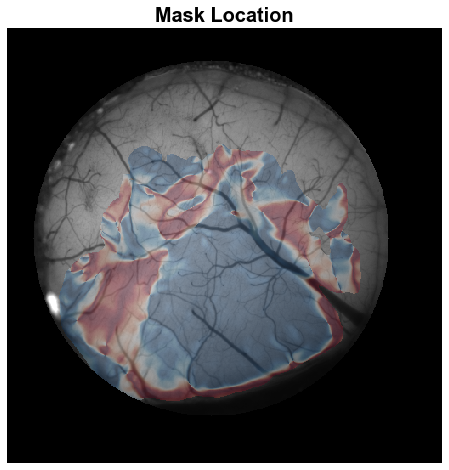

In [2]:
# Define crosshair cursor (from matplotlib documentation)
class Cursor:

    def __init__(self, ax):
        self.ax = ax
        self.horizontal_line = ax.axhline(color='k', lw=0.8, ls='--')
        self.vertical_line = ax.axvline(color='k', lw=0.8, ls='--')
        # text location in axes coordinates
        self.text = ax.text(0.72, 0.9, '', transform=ax.transAxes)

    def set_cross_hair_visible(self, visible):
        need_redraw = self.horizontal_line.get_visible() != visible
        self.horizontal_line.set_visible(visible)
        self.vertical_line.set_visible(visible)
        self.text.set_visible(visible)
        return need_redraw

    def on_mouse_move(self, event):
        if not event.inaxes:
            need_redraw = self.set_cross_hair_visible(False)
            if need_redraw:
                self.ax.figure.canvas.draw()
        else:
            self.set_cross_hair_visible(True)
            x, y = event.xdata, event.ydata
            # update the line positions
            self.horizontal_line.set_ydata(y)
            self.vertical_line.set_xdata(x)
            self.text.set_text('x=%1.2f, y=%1.2f' % (x, y))
            self.ax.figure.canvas.draw()

# Plot reference frame and get user input for center and edge points of circular mask
import matplotlib.pyplot as plt
%matplotlib qt5
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.axis('off')
ax.set_title('Select Center Point and Edge Point for Circular Mask:', fontsize=20, color='k')
fig.set_size_inches(10, 10)
cursor = Cursor(ax)
fig.canvas.mpl_connect('motion_notify_event', cursor.on_mouse_move)
mask_coors = plt.ginput(n=2, timeout=-1)
plt.close('all')

# Generate mask and get indices to set as nan
import cv2
mask = np.zeros(ref_frame.shape, dtype=np.uint8)
radius = np.linalg.norm(np.array(mask_coors[1]) - np.array(mask_coors[0]))
circle = cv2.circle(mask, (int(mask_coors[0][0]),int(mask_coors[0][1])), int(radius), (255,255,255), -1).astype('float')
circle[circle == 255] = np.nan
mask_idx = (tuple(np.where(mask == 0)[0]), tuple(np.where(mask == 0)[1]))

# Load sign map
signmap_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_retinotopy/'
signmap_file = 'signmap.csv'
signmap = np.loadtxt(signmap_path + signmap_file)

# Plot reference frame and sign map to check mask placement
%matplotlib inline
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
ax.imshow(circle, cmap='gray', alpha=1)
ax.set_title('Mask Location', fontsize=20, color='k')
ax.axis('off')
fig.set_size_inches(8, 8)

Mask Reference Frame & $\Delta$F/F Matrix

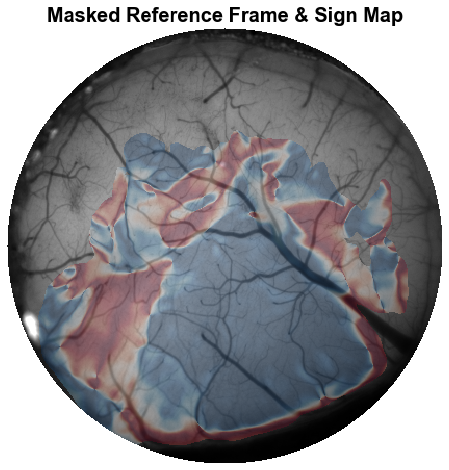

In [3]:
# Set pixel window size for correlation map
window_size = 2

# Mask reference frame and remove edges with all nan, accounting for pixel window size
np.add.at(ref_frame, mask_idx, np.nan)
row_mask = np.where(~np.isnan(ref_frame).all(axis=1))[0]
row_mask = row_mask[range(window_size * np.floor_divide(row_mask.shape[0], window_size))]
col_mask = np.where(~np.isnan(ref_frame).all(axis=0))[0]
col_mask = col_mask[range(window_size * np.floor_divide(col_mask.shape[0], window_size))]
edge_mask = np.ix_(row_mask, col_mask)
ref_frame = ref_frame[edge_mask]

# Mask sign map
np.add.at(signmap, mask_idx, np.nan)
signmap = signmap[edge_mask]

# Plot masked reference frame and sign map
%matplotlib inline
fig, ax = plt.subplots()
ax.imshow(ref_frame, cmap='gray')
ax.imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
ax.set_title('Masked Reference Frame & Sign Map', fontsize=20, color='k')
ax.axis('off')
fig.set_size_inches(8, 8)

# Mask deltaF/F matrix
dFF_masked = []
for frame in dFF:
     np.add.at(frame, mask_idx, np.nan)
     dFF_masked.append(frame[edge_mask])
dFF_masked = np.asarray(dFF_masked)

Get Visual Area Boundaries from Sign Map for Plotting against SCA Maps

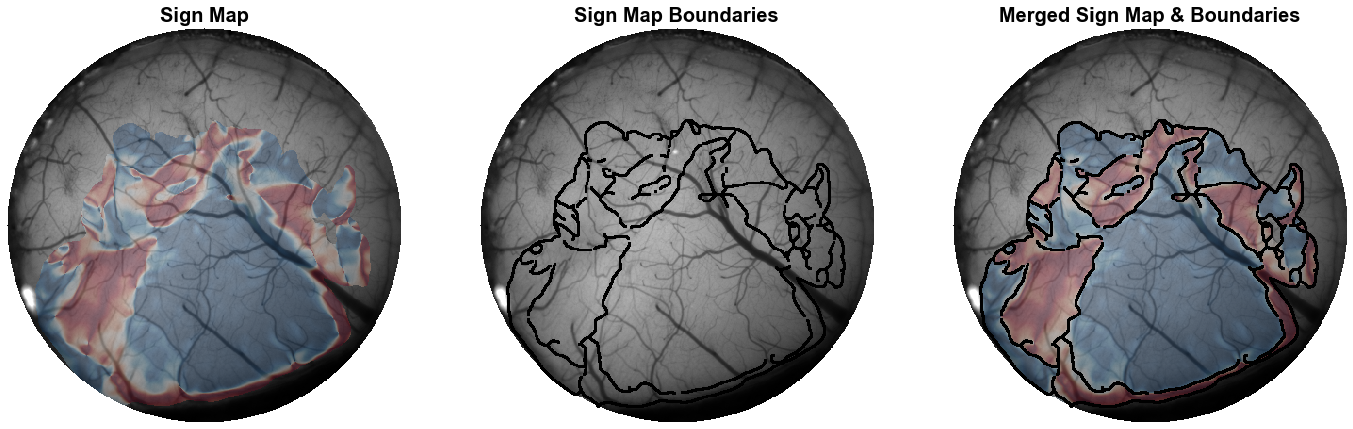

In [6]:
# Detect outer edges of sign map
def get_signmap_boundaries(signmap, dilation_factor):
    signmap_threshold = signmap.copy()
    kernel_edge = np.array([[-1, -1, -1],
                            [-1, 1, -1],
                            [-1, -1 , -1]])
    for row in np.arange(1, signmap_threshold.shape[0] - 1):
        for col in np.arange(1, signmap_threshold.shape[1] - 1):
            curr_idx = np.ix_((row - 1, row, row + 1),(col - 1, col, col + 1))
            if not (np.isnan(signmap[row,col]) and
                        np.isnan(np.tensordot(kernel_edge, signmap_threshold[curr_idx], 
                                              axes=((0,1),(0,1))))):
                signmap_threshold[curr_idx] = 0

    # Threshold sign map around 0 to detect visual area boundaries
    np.add.at(signmap_threshold, np.logical_or(signmap < -0.35, signmap > 0.35), np.nan)

    # Skeletonize, then dilate thresholded sign map
    from skimage.morphology import skeletonize
    signmap_skeleton = skeletonize(~np.isnan(signmap_threshold))
    kernel_dilate = np.ones((dilation_factor, dilation_factor), np.uint8)
    signmap_boundaries = cv2.dilate(signmap_skeleton.astype('float'), kernel_dilate, iterations=1)
    signmap_boundaries[signmap_boundaries == 0] = np.nan
    return signmap_boundaries

signmap_boundaries = get_signmap_boundaries(signmap, 3)

# Plot sign map, sign map boundaries, and merge
%matplotlib inline
fig, axs = plt.subplots(1,3)
axs[0].imshow(ref_frame, cmap='gray')
axs[0].imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
axs[0].set_title('Sign Map', fontsize=20, color='k')
axs[0].axis('off')
axs[1].imshow(ref_frame, cmap='gray')
axs[1].imshow(signmap_boundaries, cmap='Greys', clim=[0,1], alpha=1)
axs[1].set_title('Sign Map Boundaries', fontsize=20, color='k')
axs[1].axis('off')
axs[2].imshow(ref_frame, cmap='gray')
axs[2].imshow(signmap, cmap='RdBu_r', clim=[-1,1], alpha=0.3)
axs[2].imshow(signmap_boundaries, cmap='Greys', clim=[0,1], alpha=1)
axs[2].set_title('Merged Sign Map & Boundaries', fontsize=20, color='k')
axs[2].axis('off')
fig.set_size_inches(24, 8)

Generate Matrix of Window Means and Indices

In [7]:
# Get mean of windows and add data into matrix for correlation calculation by projection
window_mat = []
window_idx = np.arange(dFF_masked.shape[1]).reshape(int(dFF_masked.shape[1]/window_size), window_size)
window_idx_row = np.empty((0,0))
window_idx_col = np.empty((0,0))
for row_seed in range(int(dFF_masked.shape[1]/window_size)):
    for col_seed in range(int(dFF_masked.shape[2]/window_size)):
        window_mean = dFF_masked[np.ix_(range(dFF_masked.shape[0]),window_idx[row_seed,:],window_idx[col_seed,:])].mean(axis=(1,2))
        window_mat.append(window_mean)
        window_idx_row = np.append(window_idx_row, np.repeat(np.arange(window_size), window_size) + window_idx[row_seed,0])
        window_idx_col = np.append(window_idx_col, np.tile(np.arange(window_size), window_size) + window_idx[col_seed,0])
from scipy.stats import zscore
window_mat = zscore(np.asarray(window_mat), axis=1)

Load Azimuth and Elevation Data and Define Correlation Calculation

In [25]:
# Load and mask azimuth and elevation data
azimuth_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_retinotopy/'
azimuth_file = 'azimuth.csv'
azimuth = np.loadtxt(azimuth_path + azimuth_file)
np.add.at(azimuth, mask_idx, np.nan)
azimuth = azimuth[edge_mask]
elevation_path = '/Users/ryan.gorzek/Documents/Trachtenberg Lab/Data/Ryan/ctb09/ctb09_spontaneous_retinotopy/'
elevation_file = 'elevation.csv'
elevation = np.loadtxt(elevation_path + elevation_file)
np.add.at(elevation, mask_idx, np.nan)
elevation = elevation[edge_mask]

def calc_corr_map(in_coors):
    row_loc = np.isin(np.split(window_idx_row, len(window_idx_row) / window_size**2), in_coors[0])
    col_loc = np.isin(np.split(window_idx_col, len(window_idx_col) / window_size**2), in_coors[1])
    seed_loc = np.where(np.sum(np.concatenate((row_loc, col_loc), axis=1), axis=1) == window_size*2)[0][0]
    corr_list = np.matmul(window_mat, window_mat[seed_loc,:])/window_mat.shape[1]
    corr_list = np.repeat(corr_list, window_size**2)
    corr_mat = np.zeros((dFF_masked.shape[1], dFF_masked.shape[2]))
    corr_mat[window_idx_row.astype('int'),window_idx_col.astype('int')] = corr_list
    return corr_mat

Create PyQt GUI for Interacting with SCA Map

In [47]:
# Align slider labels with correct lines, connect lower slider with mouse wheel, 
# remove white space around figure, stylize code

import sys
from PyQt5 import QtCore, QtGui, QtWidgets
from matplotlib.backends.backend_qt5agg import FigureCanvasQTAgg, NavigationToolbar2QT as NavigationToolbar
from matplotlib.figure import Figure
from matplotlib.backend_bases import MouseButton
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter

class MplCanvas(FigureCanvasQTAgg):

    def __init__(self, parent=None, width=8, height=10, dpi=100):
        
        fig = Figure(figsize=(width, height), dpi=dpi)
        self.axes = fig.add_subplot(111)
        super(MplCanvas, self).__init__(fig)
        self.corr_bounds = [0.8, 1.0]
        self.curr_coors = [round(dFF_masked.shape[1]/2), round(dFF_masked.shape[2]/2)]
        self.corr_mat = calc_corr_map(self.curr_coors)
        self.slider_changed = False
        self.pause_map = False
        self.signmap_checked = False
        self.azimuth_checked = False
        self.elevation_checked = False
        self.binding_id = self.mpl_connect('motion_notify_event', self.map_on_move)
        self.mpl_connect('button_press_event', self.freeze_on_click)

    def map_on_move(self, event):
        if event.inaxes:
            # Recalculate SCA map for current cursor location
            if self.pause_map == False:
                self.curr_coors = np.round([event.ydata, event.xdata])
                self.corr_mat = calc_corr_map(self.curr_coors)
                # Redraw axes with new SCA map
                self.cr_im.remove()
                self.cr_im = self.axes.imshow(self.corr_mat, cmap='RdBu_r', clim=self.corr_bounds, alpha=0.5)
                self.point.remove()
                self.point = self.axes.scatter(event.xdata, event.ydata, color='k')
            if self.signmap_checked == True:
                self.sb_im.remove()
                self.sb_im = self.axes.imshow(signmap_boundaries, cmap='Greys', clim=[0,1], alpha=1)
            if self.azimuth_checked == True:
                for artist in self.az_ct.collections:
                    artist.remove()
                self.az_ct = self.axes.contour(azimuth, levels=np.arange(0, 144, 7.5), cmap='jet_r', alpha=1, linewidths=0.5)
            if self.elevation_checked == True:
                for artist in self.el_ct.collections:
                    artist.remove()
                self.el_ct = self.axes.contour(elevation, levels=np.arange(0, 100, 5), cmap='jet_r', alpha=1, linewidths=0.5)
            if self.slider_changed == True:
                self.cb_ax.remove()
                self.cb_ax = inset_axes(self.axes, width='5%', height='90%', loc='center left', borderpad=-5)
                colorbar = fig.colorbar(self.cr_im, cax=self.cb_ax)
                colorbar.set_label('Pearson Correlation Coefficient', color='k', fontsize=20)
                self.cb_ax.yaxis.tick_left()
                self.cb_ax.yaxis.set_label_position('left')
                self.cb_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                self.cb_ax.tick_params(labelsize=15)
                self.slider_changed = False
            self.draw()

    def freeze_on_click(self, event):

        if (event.button is MouseButton.LEFT) & (self.pause_map == False):
            self.pause_map = True
        elif (event.button is MouseButton.LEFT) & (self.pause_map == True):
            self.pause_map = False

class MainWindow(QtWidgets.QMainWindow):

    def __init__(self, *args, **kwargs):
        super(MainWindow, self).__init__(*args, **kwargs)

        sc = MplCanvas(self, width=8, height=10, dpi=100)
        sc.axes.imshow(ref_frame, cmap='gray')
        sc.cr_im = sc.axes.imshow(sc.corr_mat, cmap='RdBu_r', clim=sc.corr_bounds, alpha=0.5)
        sc.point = sc.axes.scatter(sc.curr_coors[1], sc.curr_coors[0], color='k')
        sc.cb_ax = inset_axes(sc.axes, width='5%', height='90%', loc='center left', borderpad=-5)
        colorbar = fig.colorbar(sc.cr_im, cax=sc.cb_ax)
        colorbar.set_label('Pearson Correlation Coefficient', color='k', fontsize=20)
        sc.cb_ax.yaxis.tick_left()
        sc.cb_ax.yaxis.set_label_position('left')
        sc.cb_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        sc.cb_ax.tick_params(labelsize=15)
        sc.axes.axis('off')
        # sc.axes.margins(x=0, y=0)

        # Create toolbar, passing canvas as first parament, parent (self, the MainWindow) as second.
        toolbar = NavigationToolbar(sc, self)

        self.corr_slider_max = QtWidgets.QSlider(QtCore.Qt.Vertical)
        self.corr_slider_max.setMinimum(-100)
        self.corr_slider_max.setMaximum(100)
        self.corr_slider_max.setTickPosition(QtWidgets.QSlider.TicksLeft)
        self.corr_slider_max.setTickInterval(5)
        self.corr_slider_min = QtWidgets.QSlider(QtCore.Qt.Vertical)
        self.corr_slider_min.setMinimum(-100)
        self.corr_slider_min.setMaximum(100)
        self.corr_slider_min.setTickPosition(QtWidgets.QSlider.TicksLeft)
        self.corr_slider_min.setTickInterval(5)
        self.corr_slider_max.valueChanged.connect(lambda state, ax = sc: self.sliderValueChange(state, ax))
        self.corr_slider_min.valueChanged.connect(lambda state, ax = sc: self.sliderValueChange(state, ax))
        self.corr_slider_max.setValue(100)
        self.corr_slider_min.setValue(80)
        
        self.slider_max_label = QtWidgets.QLabel()
        self.slider_max_label.setText('Maximum Correlation Bound')
        self.slider_max_label.setWordWrap(True)
        self.slider_max_label.setAlignment(QtCore.Qt.AlignCenter)

        self.slider_max_10_label = QtWidgets.QLabel()
        self.slider_max_10_label.setText('1.0')
        self.slider_max_10_label.setAlignment(QtCore.Qt.AlignRight)
        self.slider_max_05_label = QtWidgets.QLabel()
        self.slider_max_05_label.setText('0.5')
        self.slider_max_05_label.setAlignment(QtCore.Qt.AlignRight)
        self.slider_max_00_label = QtWidgets.QLabel()
        self.slider_max_00_label.setText('0.0')
        self.slider_max_00_label.setAlignment(QtCore.Qt.AlignRight)
        self.slider_max_n05_label = QtWidgets.QLabel()
        self.slider_max_n05_label.setText('-0.5')
        self.slider_max_n05_label.setAlignment(QtCore.Qt.AlignRight)
        self.slider_max_n10_label = QtWidgets.QLabel()
        self.slider_max_n10_label.setText('-1.0')
        self.slider_max_n10_label.setAlignment(QtCore.Qt.AlignRight)
        
        self.slider_min_label = QtWidgets.QLabel()
        self.slider_min_label.setText('Minimum Correlation Bound')
        self.slider_min_label.setWordWrap(True)
        self.slider_min_label.setAlignment(QtCore.Qt.AlignCenter)
        
        self.slider_min_10_label = QtWidgets.QLabel()
        self.slider_min_10_label.setText('1.0')
        self.slider_min_10_label.setAlignment(QtCore.Qt.AlignRight)
        self.slider_min_05_label = QtWidgets.QLabel()
        self.slider_min_05_label.setText('0.5')
        self.slider_min_05_label.setAlignment(QtCore.Qt.AlignRight)
        self.slider_min_00_label = QtWidgets.QLabel()
        self.slider_min_00_label.setText('0.0')
        self.slider_min_00_label.setAlignment(QtCore.Qt.AlignRight)
        self.slider_min_n05_label = QtWidgets.QLabel()
        self.slider_min_n05_label.setText('-0.5')
        self.slider_min_n05_label.setAlignment(QtCore.Qt.AlignRight)
        self.slider_min_n10_label = QtWidgets.QLabel()
        self.slider_min_n10_label.setText('-1.0')
        self.slider_min_n10_label.setAlignment(QtCore.Qt.AlignRight)
        
        self.signmap_checkbox = QtWidgets.QCheckBox('Sign Map Boundaries', self)
        self.signmap_checkbox.setFont(QtGui.QFont('Arial', 20))
        self.azimuth_checkbox = QtWidgets.QCheckBox('Azimuth', self)
        self.azimuth_checkbox.setFont(QtGui.QFont('Arial', 20))
        self.elevation_checkbox = QtWidgets.QCheckBox('Elevation', self)
        self.elevation_checkbox.setFont(QtGui.QFont('Arial', 20))
        self.signmap_checkbox.stateChanged.connect(
            lambda state, checkbox_name = 'Sign Map Boundaries', ax = sc: self.clickBox(state, checkbox_name, ax))
        self.azimuth_checkbox.stateChanged.connect(
            lambda state, checkbox_name = 'Azimuth', ax = sc: self.clickBox(state, checkbox_name, ax))
        self.elevation_checkbox.stateChanged.connect(
            lambda state, checkbox_name = 'Elevation', ax = sc: self.clickBox(state, checkbox_name, ax))

        # Create grid layout and add widgets.
        layout = QtWidgets.QGridLayout()
        layout.addWidget(toolbar, 0, 0, 1, 8)
        layout.addWidget(sc, 2, 2, 22, 6)
        
        layout.addWidget(self.signmap_checkbox, 1, 2, 1, 2, QtCore.Qt.AlignCenter)
        layout.addWidget(self.azimuth_checkbox, 1, 4, 1, 2, QtCore.Qt.AlignCenter)
        layout.addWidget(self.elevation_checkbox, 1, 6, 1, 2, QtCore.Qt.AlignCenter)
        
        layout.addWidget(self.slider_max_label, 2, 0, 1, 2, QtCore.Qt.AlignCenter)
        layout.addWidget(self.slider_max_10_label, 3, 0, 1, 1, QtCore.Qt.AlignRight)
        layout.addWidget(self.slider_max_05_label, 5, 0, 1, 1, QtCore.Qt.AlignBottom)
        layout.addWidget(self.slider_max_00_label, 7, 0, 2, 1, QtCore.Qt.AlignVCenter)
        layout.addWidget(self.slider_max_n05_label, 10, 0, 1, 1, QtCore.Qt.AlignRight)
        layout.addWidget(self.slider_max_n10_label, 12, 0, 1, 1, QtCore.Qt.AlignBottom)
        layout.addWidget(self.corr_slider_max, 3, 1, 10, 2, QtCore.Qt.AlignLeft) # max slider
        
        layout.addWidget(self.slider_min_label, 13, 0, 1, 2, QtCore.Qt.AlignCenter)
        layout.addWidget(self.slider_min_10_label, 14, 0, 1, 1, QtCore.Qt.AlignRight)
        layout.addWidget(self.slider_min_05_label, 16, 0, 1, 1, QtCore.Qt.AlignBottom)
        layout.addWidget(self.slider_min_00_label, 18, 0, 2, 1, QtCore.Qt.AlignVCenter)
        layout.addWidget(self.slider_min_n05_label, 21, 0, 1, 1, QtCore.Qt.AlignRight)
        layout.addWidget(self.slider_min_n10_label, 23, 0, 1, 1, QtCore.Qt.AlignBottom)
        layout.addWidget(self.corr_slider_min, 14, 1, 10, 2, QtCore.Qt.AlignLeft) # min slider

        # Create a placeholder widget to hold our toolbar and canvas.
        widget = QtWidgets.QWidget()
        widget.setLayout(layout)
        self.setCentralWidget(widget)
        self.show()
        
    def clickBox(self, state, checkbox_name, ax):
        if (checkbox_name == 'Sign Map Boundaries') & (state == QtCore.Qt.Checked):
            ax.signmap_checked = True
            ax.sb_im = ax.axes.imshow(signmap_boundaries, cmap='Greys', clim=[0,1], alpha=1)
            ax.draw()
        elif (checkbox_name == 'Sign Map Boundaries') & (state == QtCore.Qt.Unchecked):
            ax.signmap_checked = False
            ax.sb_im.remove()
            ax.draw()
        if (checkbox_name == 'Azimuth') & (state == QtCore.Qt.Checked):
            ax.azimuth_checked = True
            ax.az_ct = ax.axes.contour(azimuth, levels=np.arange(0, 144, 7.5), cmap='jet_r', alpha=1, linewidths=0.5)
            ax.draw()
        elif (checkbox_name == 'Azimuth') & (state == QtCore.Qt.Unchecked):
            ax.azimuth_checked = False
            for artist in ax.az_ct.collections:
                artist.remove()
            ax.draw()
        if (checkbox_name == 'Elevation') & (state == QtCore.Qt.Checked):
            ax.elevation_checked = True
            ax.el_ct = ax.axes.contour(elevation, levels=np.arange(0, 100, 5), cmap='jet_r', alpha=1, linewidths=0.5)
            ax.draw()
        elif (checkbox_name == 'Elevation') & (state == QtCore.Qt.Unchecked):
            ax.elevation_checked = False
            for artist in ax.el_ct.collections:
                artist.remove()
            ax.draw()
            
    def sliderValueChange(self, state, ax):
        if self.corr_slider_max.value() >= self.corr_slider_min.value():
            ax.slider_changed = True
            ax.corr_bounds = [self.corr_slider_min.value()/100, self.corr_slider_max.value()/100]
            ax.cr_im.remove()
            ax.cr_im = ax.axes.imshow(ax.corr_mat, cmap='RdBu_r', clim=ax.corr_bounds, alpha=0.5)
            if ax.signmap_checked == True:
                ax.sb_im.remove()
                ax.sb_im = ax.axes.imshow(signmap_boundaries, cmap='Greys', clim=[0,1], alpha=1)
            ax.cb_ax.remove()
            ax.cb_ax = inset_axes(ax.axes, width='5%', height='90%', loc='center left', borderpad=-5)
            colorbar = fig.colorbar(ax.cr_im, cax=ax.cb_ax)
            colorbar.set_label('Pearson Correlation Coefficient', color='k', fontsize=20)
            ax.cb_ax.yaxis.tick_left()
            ax.cb_ax.yaxis.set_label_position('left')
            ax.cb_ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.cb_ax.tick_params(labelsize=15)
            ax.draw()

app = QtCore.QCoreApplication.instance()
if app is None:
    app = QtWidgets.QApplication(sys.argv)
w = MainWindow()
app.exec_()

0